# 02 - Feature Store
The idea of this notebook is to create the master feature store based on the training dataset generate in `Code/01_DataPreparation.ipynb`. Please ensure the training dataset is generated.

### Feature Ideas
The idea behind the feature is to generate 4 broader set of features which will depict the re-ordering probability
<enumerate>
<li> User features - Which track the features of the users like segment, ordering frequency, product likes, preference to new items etc..
<li> Product Feature - Tracks information on product around streak, position in cart, re-ordering, time between orders etc..
<li> User-Product Combination - Tracks repetitive orders based on time b/w orders, co-occurences, replacements etc..
<li> All other meta information - This includes external factors like timestamps and potentially product placement in aisles
</enumerate>

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import Word2Vec
from matplotlib.colors import to_hex

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
warnings.filterwarnings("ignore")
sns.set_theme("paper")

[nltk_data] Downloading package stopwords to /Users/sid98/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sid98/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
og_df = pd.read_csv("../Dataset/TrainingDataset.csv", index_col=0)
meta_data = pd.read_csv("../Dataset/Metadata.csv", index_col=0)

In [64]:
df = og_df[og_df.order_number < 3].reset_index(drop=True) ### Subsetting to speenden the computation
trainDf = og_df[og_df.order_number == 3]

## Base Features

In [65]:
user_product_orders = df.drop_duplicates(subset=["user_id", "product_id"])[["user_id", "product_id"]]
trainDf = user_product_orders.merge(trainDf, on=["user_id", "product_id"], how="left").sort_values(by=["user_id"]).reset_index(drop=True)

trainDf["reordered"] = trainDf["reordered"].fillna(0)
trainDf["cart_order"] = trainDf["cart_order"].fillna(1)

reordered = trainDf["reordered"]
trainDf["reordered"] = 1

trainDf = trainDf.fillna(method="ffill")

In [72]:
orders = pd.concat([df, trainDf], ignore_index=True).reset_index(drop=True)

In [73]:
order_features = orders.groupby("order_id").agg(
    cart_size = ("product_id", "count"), 
    reorder_ratio = ("reordered", "mean"),
).reset_index()

orders = orders.merge(order_features, left_on="order_id", right_on="order_id")

## User - Product usage (Days since last order of this item by this user)
orders["last_order_number"] = orders.groupby(['user_id', 'product_id'])["order_number"].shift(1)

temp = orders.drop_duplicates(subset=["user_id", "order_number"])[["user_id", "order_number", "days_since_prior_order"]]
temp["days_since_first_order"] = temp.groupby(["user_id"])["days_since_prior_order"].cumsum()
temp["last_order_number"] = temp["order_number"]

orders = orders.merge(temp[["user_id", "order_number", "days_since_first_order"]], left_on=["user_id", "order_number"], right_on=["user_id", "order_number"], how="left")
orders = orders.rename(columns={"days_since_first_order": "curr_order_days_since_first_order"})

orders = orders.merge(temp[["user_id", "last_order_number", "days_since_first_order"]], left_on=["user_id", "last_order_number"], right_on=["user_id", "last_order_number"], how="left")
orders = orders.rename(columns={"days_since_first_order": "prev_order_days_since_first_order"})

orders["curr_order_days_since_first_order"] = orders["curr_order_days_since_first_order"].fillna(0)
orders["prev_order_days_since_first_order"] = orders["reordered"]*(orders["last_order_number"]/orders["last_order_number"])*orders["prev_order_days_since_first_order"].fillna(0)
orders.loc[:,"days_since_prev_order_item"] = orders["curr_order_days_since_first_order"] - orders["prev_order_days_since_first_order"]

orders = orders.drop(["curr_order_days_since_first_order", "prev_order_days_since_first_order"], axis=1)

orders["last_order_num_diff"] = orders["order_number"] - orders["last_order_number"]
orders["item_in_every_order"] = ((orders["order_number"] - orders["last_order_number"]) == 1).astype(int)
orders["item_in_every_2_order"] = ((orders["order_number"] - orders["last_order_number"]) == 2).astype(int)
orders["item_in_every_3_order"] = ((orders["order_number"] - orders["last_order_number"]) == 3).astype(int)
orders["item_in_every_4_order"] = ((orders["order_number"] - orders["last_order_number"]) == 4).astype(int)
orders["item_in_every_5_order"] = ((orders["order_number"] - orders["last_order_number"]) == 4).astype(int)
del temp, order_features
gc.collect()

0

In [77]:
df = orders[orders.order_number < 3].reset_index(drop=True)
trainDf = orders[orders.order_number == 3].reset_index(drop=True)
trainDf["reordered"] = reordered

## User Features 

In [78]:
user_base_features = df.groupby("user_id").agg(
    total_orders = ("order_number", "max"), ## app liking
    avg_time_between_orders = ("days_since_prior_order", "mean"), ## app loyalty
    usual_buying_time = ("order_hour_of_day", "median"), ## buying pattern
    usual_buying_day = ("order_dow", "median"), ## buying pattern
    total_unique_products_bought = ("product_id", "nunique"), ## new product recommendation
).reset_index()

first_product_reordered = df[((df.cart_order == 1) & (df.order_number != 1))].groupby("user_id")["reordered"].mean().reset_index(name="first_product_reordered")
user_base_features = user_base_features.merge(first_product_reordered, on="user_id", how="left")

temp = df[df.order_number != 1].groupby(["user_id", "order_id"])["reordered"].sum().reset_index()
temp["complete_new_order"] = (temp["reordered"] == 0).astype(int)
new_order = temp.groupby("user_id")["complete_new_order"].mean().reset_index()
m = user_base_features.merge(new_order, on="user_id", how="left")

user_order_features = df[df.order_number != 1].groupby(["user_id", "order_number"]).agg(
    product_per_order = ("product_id", "count"), ## buying nature
    reorder_ratio_per_order = ("reordered", "mean"),  ## buying nature
).reset_index()

user_order_features = user_order_features.groupby("user_id").agg(
    average_product_per_order = ("product_per_order", "median"), ## buying nature
    average_reorder_ratio_per_order = ("reorder_ratio_per_order", "mean"), ## buying nature
).reset_index()

user_features = user_base_features.merge(user_order_features, on="user_id", how="left")

del user_order_features, temp, new_order, first_product_reordered, user_base_features
gc.collect()
user_features.columns = [col + "_user" if col != "user_id" else col for col in user_features.columns]

## Product Features

In [79]:
product_base_features = df.groupby("product_id").agg(
    reorder_ratio = ("reordered", "mean"), ## Product popularity
    total_purchases = ("order_id", "count"), ## Overall interest
    usual_position_in_cart = ("cart_order", "median"), ## Type of product [Needs/Wants/Last minute impulse]
    avg_cart_size = ("cart_size", "mean"), ## Part of staple order or not
    usual_buying_time = ("order_hour_of_day", "median"), ## buying pattern
    usual_buying_day = ("order_dow", "median"), ## buying pattern
).reset_index()

user_product_base_features = df.groupby(["user_id", "product_id"]).agg(
    total_orders = ("order_id", "nunique"), ## Staple/single shots
    usual_cart_position = ("cart_order", "median")).reset_index() ## User's view on this product (Need/Want),

single_order_ratio = (user_product_base_features[user_product_base_features['total_orders'] == 1].groupby('product_id').size() / user_product_base_features.groupby('product_id').size()).reset_index(name="one_shot_ratio")
unique_users = user_product_base_features.groupby('product_id').size().reset_index(name="unique_users")
product_features = product_base_features.merge(single_order_ratio, on="product_id", how="left")
product_features = product_features.merge(unique_users, on="product_id", how="left")
product_features["one_shot_ratio"] = product_features["one_shot_ratio"].fillna(0)

product_features.columns = [col+"_product" if col != "product_id" else col for col in product_features.columns if col]

del product_base_features, single_order_ratio, unique_users
gc.collect()

0

## User Product Features

In [81]:
# dow = df.drop_duplicates('order_id').groupby('order_dow').size()
# dow.name = 'dow_order_cnt'
# dow = dow.to_frame()
# dow['dow_item_cnt'] = df.groupby('order_dow').size()
# dow /= dow.sum()
# dow['dow_rank_diff'] = dow.dow_order_cnt.rank() - dow.dow_item_cnt.rank()

# hour = df.drop_duplicates('order_id').groupby('order_hour_of_day').size()
# hour.name = 'hour_order_cnt'
# hour = hour.to_frame()
# hour['hour_item_cnt'] = df.groupby('order_hour_of_day').size()
# hour /= hour.sum()
# hour['hour_rank_diff'] = hour.hour_order_cnt.rank() - hour.hour_item_cnt.rank()

## Materialize

In [82]:
data = pd.merge(user_product_features.merge(product_features, on="product_id"), user_features, on="user_id")

In [83]:
trainDf["products_ordered_in_this_order"] = trainDf["cart_order"] - 1
trainDf = trainDf[["user_id", "product_id", "order_number", "order_dow", "order_hour_of_day", "days_since_prior_order", "days_since_prev_order_item", "last_order_number", "products_ordered_in_this_order", "reordered"]]
trainingDf = data.merge(trainDf, on=["user_id", "product_id"], how="left")

In [84]:
trainingDf = trainingDf[["user_id", "product_id", 

             "order_number", "last_order_number", "order_dow", "order_hour_of_day", "days_since_prior_order",
             "days_since_prev_order_item", "products_ordered_in_this_order", ## Current order Features

             "total_orders_uxp", "usual_cart_position_uxp", "streak_chance_uxp", "item_n2_chance_uxp", "item_n3_chance_uxp", 
             "item_n4_chance_uxp", "item_n5_chance_uxp", "average_reorder_time_uxp", ## Uxp Features

             "reorder_ratio_product", "total_purchases_product", "usual_position_in_cart_product", "avg_cart_size_product",
             "usual_buying_time_product", "usual_buying_day_product", "one_shot_ratio_product", "unique_users_product", ## Prod Features

             "total_orders_user", "avg_time_between_orders_user", "usual_buying_time_user", "usual_buying_day_user", "total_unique_products_bought_user",
             "first_product_reordered_user", "complete_new_order_user", "average_product_per_order_user", "average_reorder_ratio_per_order_user", ## User Features
             
             "reordered"]]

In [90]:
trainingDf.head()

,user_id,product_id,order_number,last_order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_prev_order_item,products_ordered_in_this_order,total_orders_uxp,...,total_orders_user,avg_time_between_orders_user,usual_buying_time_user,usual_buying_day_user,total_unique_products_bought_user,first_product_reordered_user,complete_new_order_user,average_product_per_order_user,average_reorder_ratio_per_order_user,reordered
0,1,196,3.0,2.0,3.0,12.0,21.0,21.0,0.0,2,...,2.0,15.0,7.0,3.0,8,1.0,0.0,6.0,0.5,1.0
1,1,10258,3.0,2.0,3.0,12.0,21.0,21.0,2.0,1,...,2.0,15.0,7.0,3.0,8,1.0,0.0,6.0,0.5,1.0
2,1,12427,3.0,2.0,3.0,12.0,21.0,21.0,1.0,2,...,2.0,15.0,7.0,3.0,8,1.0,0.0,6.0,0.5,1.0
3,1,13032,3.0,2.0,3.0,12.0,21.0,21.0,0.0,1,...,2.0,15.0,7.0,3.0,8,1.0,0.0,6.0,0.5,0.0
4,1,13176,3.0,2.0,3.0,12.0,21.0,21.0,0.0,1,...,2.0,15.0,7.0,3.0,8,1.0,0.0,6.0,0.5,0.0


In [93]:
import pandas as pd
import numpy as np
import os
import warnings
import gc
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def dummyTraining(trainingDf, testDf=None):
    features = [
             "order_number", "last_order_number", "order_dow", "order_hour_of_day", "days_since_prior_order",
             "days_since_prev_order_item", ## Current order Features

             "total_orders_uxp", "usual_cart_position_uxp", "streak_chance_uxp", "item_n2_chance_uxp", "item_n3_chance_uxp", 
             "item_n4_chance_uxp", "item_n5_chance_uxp", "average_reorder_time_uxp", ## Uxp Features

             "reorder_ratio_product", "total_purchases_product", "usual_position_in_cart_product", "avg_cart_size_product",
             "usual_buying_time_product", "usual_buying_day_product", "one_shot_ratio_product", "unique_users_product", ## Prod Features

             "total_orders_user", "avg_time_between_orders_user", "usual_buying_time_user", "usual_buying_day_user", "total_unique_products_bought_user",
             "first_product_reordered_user", "complete_new_order_user", "average_product_per_order_user", "average_reorder_ratio_per_order_user", ## User Features
    ]

    X = trainingDf[features]
    y = trainingDf["reordered"]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert the dataset into a DMatrix object, which is a data structure that XGBoost uses for optimized data handling
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X, label=y)

    # Set the parameters for the XGBoost model
    params = {
        'max_depth': 3, 
        'eta': 0.1, 
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }

    # Train the XGBoost model
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)

    # Make predictions on the test set
    y_pred_prob = bst.predict(dtest)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)

    # Evaluate the model
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    class_report = classification_report(y, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)


    importance_scores = bst.get_score(importance_type='weight')
    # Convert the scores into a DataFrame for better readability
    importance_df = pd.DataFrame({
        'Feature': list(importance_scores.keys()),
        'Importance': list(importance_scores.values())
    }).sort_values(by='Importance', ascending=False)

    # Display the feature importance DataFrame
    print(importance_df)

    # Plot the feature importance
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(bst, importance_type='weight')
    plt.title('Feature Importance')
    plt.show()

Accuracy: 0.9682
Confusion Matrix:
[[2767585    8769]
 [ 104703  687458]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98   2776354
         1.0       0.99      0.87      0.92    792161

    accuracy                           0.97   3568515
   macro avg       0.98      0.93      0.95   3568515
weighted avg       0.97      0.97      0.97   3568515

                                 Feature  Importance
4         products_ordered_in_this_order        87.0
6                usual_cart_position_uxp        85.0
8                  reorder_ratio_product        38.0
15     total_unique_products_bought_user        38.0
3             days_since_prev_order_item        33.0
12                one_shot_ratio_product        32.0
2                 days_since_prior_order        21.0
10        usual_position_in_cart_product        21.0
7               average_reorder_time_uxp        19.0
5                       total_orders_uxp      

<Figure size 1000x800 with 0 Axes>

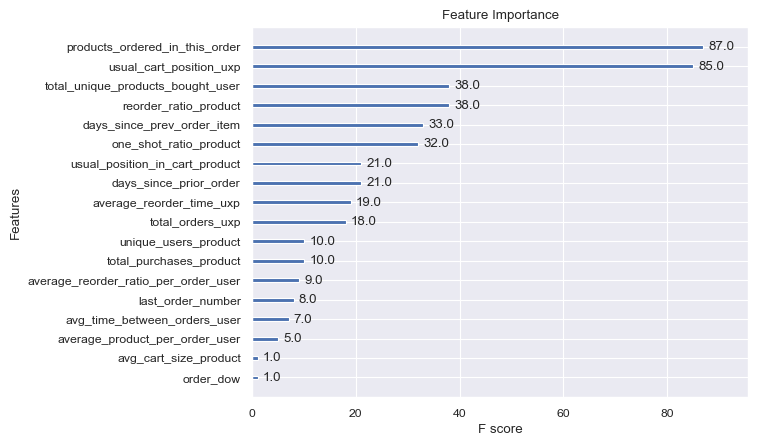

In [92]:
dummyTraining(trainingDf)

Accuracy: 0.7953
Confusion Matrix:
[[2666272  110082]
 [ 620272  171889]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88   2776354
         1.0       0.61      0.22      0.32    792161

    accuracy                           0.80   3568515
   macro avg       0.71      0.59      0.60   3568515
weighted avg       0.77      0.80      0.76   3568515

                                 Feature  Importance
3                 days_since_prior_order       120.0
6                usual_cart_position_uxp        76.0
19        average_product_per_order_user        73.0
4             days_since_prev_order_item        70.0
20  average_reorder_ratio_per_order_user        68.0
12                one_shot_ratio_product        57.0
8                  reorder_ratio_product        46.0
14          avg_time_between_orders_user        42.0
9                total_purchases_product        30.0
0                      last_order_number      

<Figure size 1000x800 with 0 Axes>

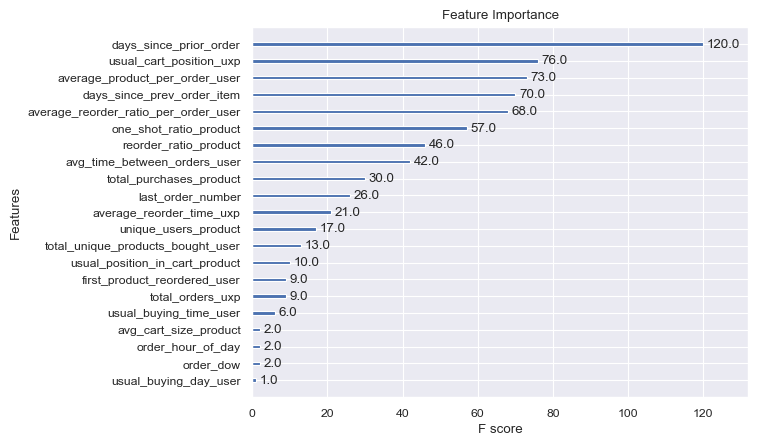

In [94]:
dummyTraining(trainingDf)

## User Segmentation

...10
...30
...50
...70
...90
...110
...130


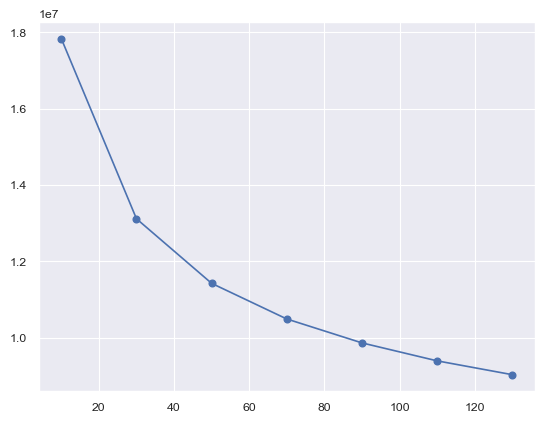

In [26]:
user_product_cnt = df.groupby(["user_id", "product_id"])["order_id"].count().reset_index()
user_product_cnt = user_product_cnt.merge(meta_data, on="product_id")

user_dept_buys = user_product_cnt.groupby(["user_id", "department"])["order_id"].sum().reset_index()
user_aisle_buys = user_product_cnt.groupby(["user_id", "aisle"])["order_id"].sum().reset_index()

user_dept_buys = pd.pivot_table(data=user_dept_buys, index="user_id", columns="department", values="order_id")
user_dept_buys = user_dept_buys.fillna(0).reset_index()

user_aisle_buys = pd.pivot_table(data=user_aisle_buys, index="user_id", columns="aisle", values="order_id")
user_aisle_buys = user_aisle_buys.fillna(0).reset_index()

user_segment_features = user_features.merge(user_dept_buys, on="user_id")
user_segment_features = user_segment_features.merge(user_aisle_buys, on="user_id")

# Separate dense and sparse data
dense_data = user_segment_features.iloc[:,1:9]
sparse_data = user_segment_features.iloc[:,9:]

# Standardize dense data
scaler = StandardScaler()
dense_scaled = scaler.fit_transform(dense_data)

svd = TruncatedSVD(n_components=10)
sparse_svd = svd.fit_transform(sparse_data)

combined_data = pd.concat([pd.DataFrame(dense_scaled), pd.DataFrame(sparse_svd)], axis=1)

inertia = []
K = range(10, 150, 20)
for k in K:
    print(f"...{k}")
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_data)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')


In [27]:
kmeans = KMeans(n_clusters=50, random_state=42)
user_segment = kmeans.fit_predict(combined_data)
user_features.loc[:,"user_segment"] = user_segment

In [28]:
del user_segment_features, user_aisle_buys, user_dept_buys, user_product_cnt, kmeans, combined_data, inertia, K
gc.collect()

12

## Product Segmenation based on Aisle - Derpartment

Currently the products could be segmented purely based on aisle and department into 134 categories. But this category is not very clear and created very sparse dataset. Using the description of the products along with aisle and department they are positioned in, using Word2Vec, the text is vectorized. Then using this vector the products are categorized into 10 distinc categories which are believed to be a better representation of their use.

For eg: Instant foods and Canned foods don't have to be in different categories

In [29]:
meta_data["name"] = meta_data["product_name"] + " in " + meta_data["department"] + " department placed in " + meta_data["aisle"] + " aisle "

# Tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words

meta_data["name_filtered"] = meta_data['name'].apply(tokenize_and_remove_stopwords)

# Train a Word2Vec model
sentences = meta_data['name_filtered'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=1000, window=3, min_count=1, workers=4) ### Because by default we have dept*aisle dimensions of sparse dataset
embeddings = meta_data['name_filtered'].apply(lambda x: word2vec_model.wv[x].mean(axis=0))

,product_id,reorder_ratio_product,total_purchases_product,usual_position_in_cart_product,avg_cart_size_product,usual_buying_time_product,usual_buying_day_product,one_shot_ratio_product,unique_users_product
0,1,0.157895,285,4.0,9.887719,13.0,3.0,0.845833,240
1,2,0.083333,12,9.0,16.666667,11.5,3.0,0.909091,11
2,3,0.351852,54,5.5,14.907407,14.0,2.0,0.600000,35
3,4,0.232759,116,9.0,16.431034,14.0,2.5,0.752809,89
4,5,0.000000,2,5.0,11.500000,13.0,3.0,1.000000,2
...,...,...,...,...,...,...,...,...,...
47442,49684,0.250000,4,5.5,10.000000,11.0,4.5,0.666667,3
47443,49685,0.166667,12,4.0,13.833333,13.5,2.0,0.800000,10
47444,49686,0.285714,14,8.0,12.642857,11.0,5.0,0.700000,10
47445,49687,0.000000,2,2.0,8.000000,12.0,4.0,1.000000,2


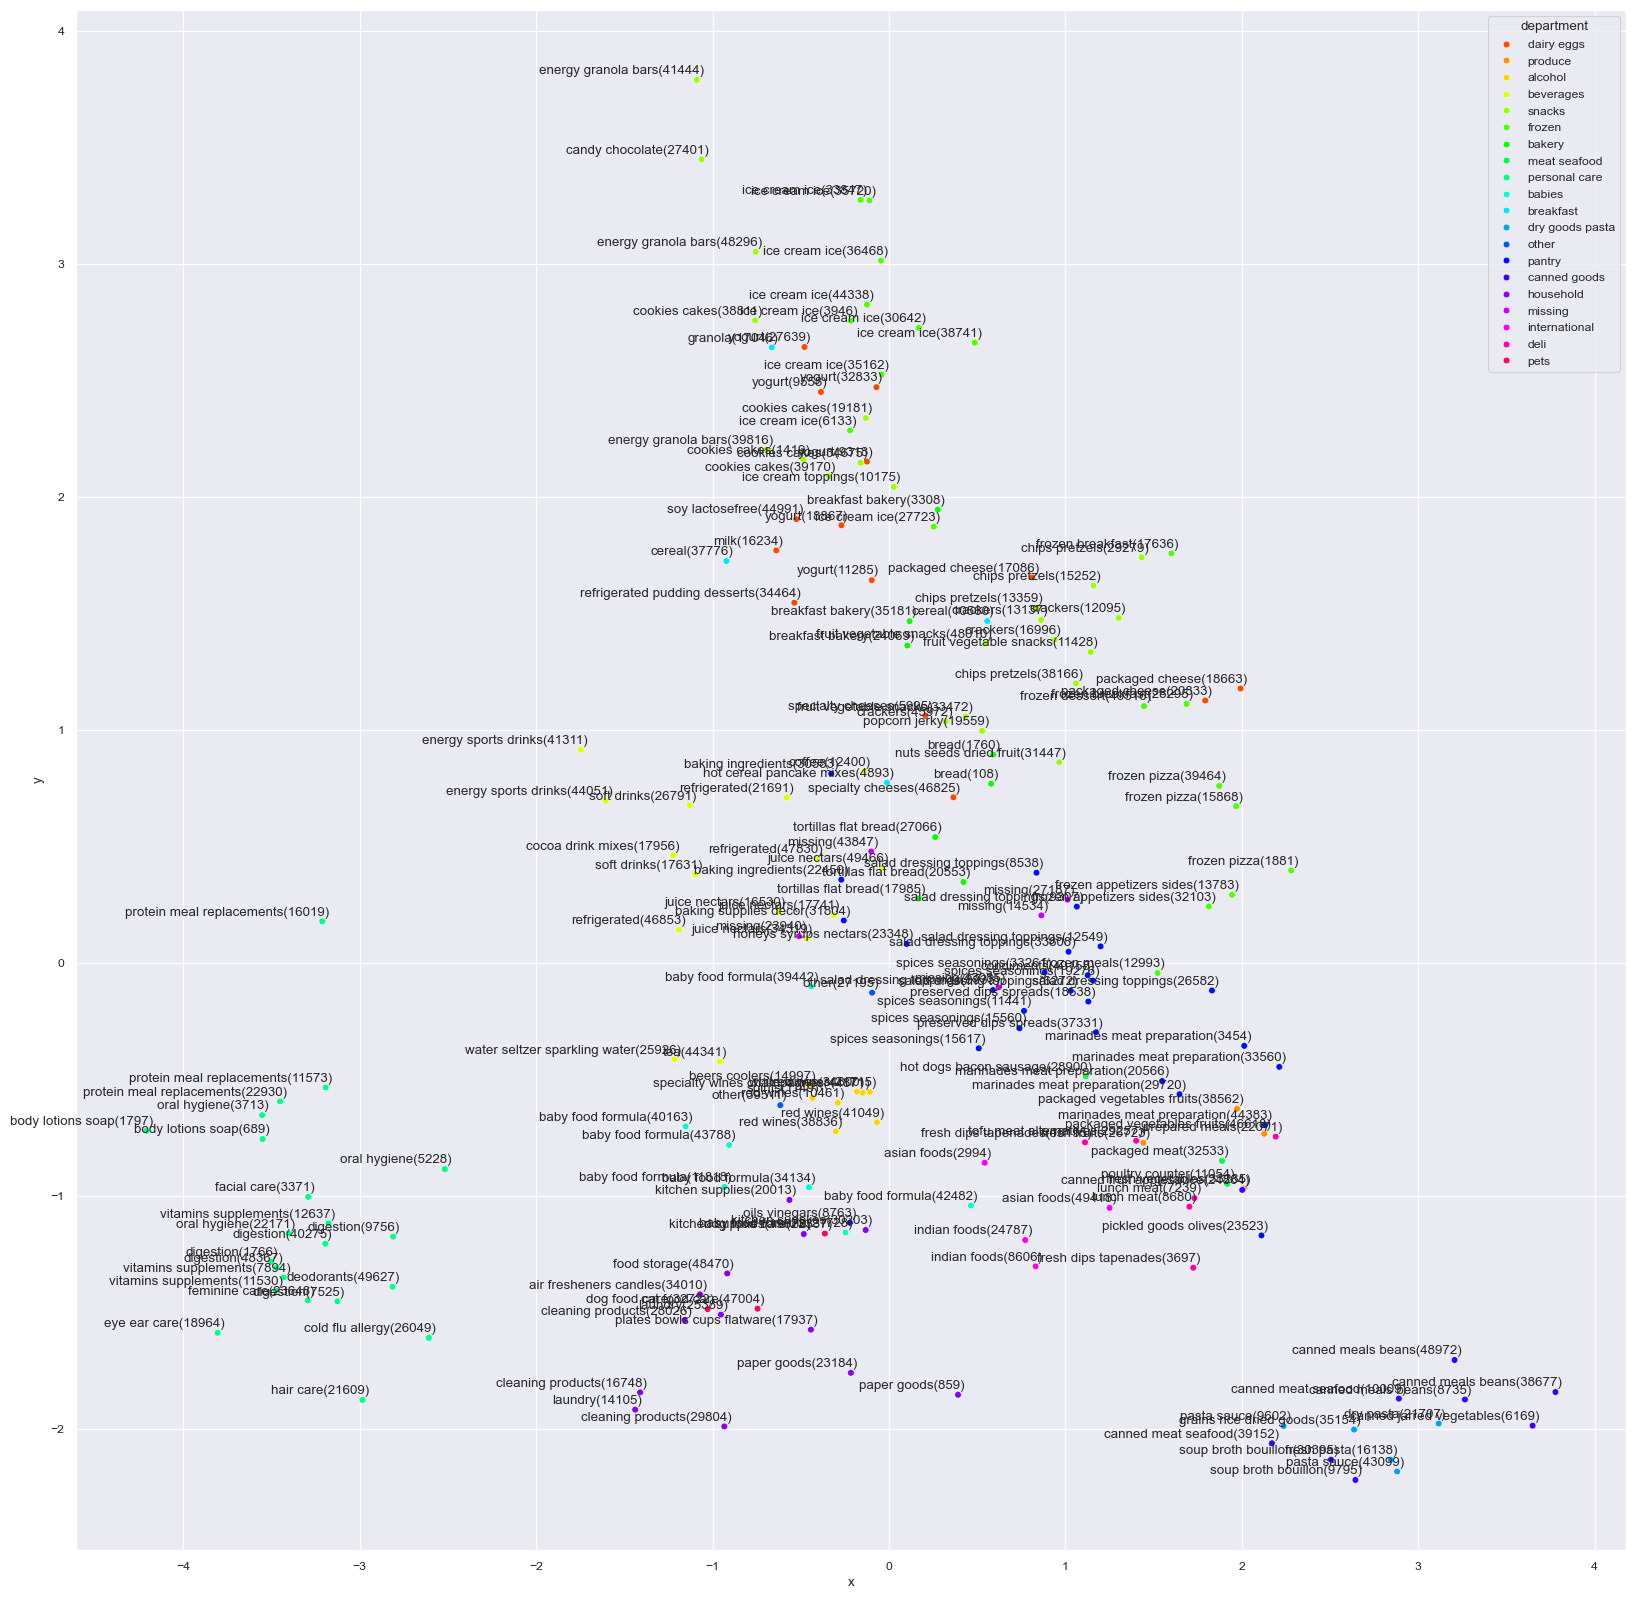

In [30]:
pca = PCA(n_components=2)
pca.fit(list(embeddings.apply(lambda x: list(x)).values))
viz_embeddings = pca.transform(list(embeddings.apply(lambda x: list(x)).values))

random_product_ids = np.random.default_rng().choice(meta_data.shape[0], size=200, replace=False)
viz_embeddings_scaled = pd.DataFrame(viz_embeddings[random_product_ids,:])
viz_embeddings_scaled.index = random_product_ids
meta_data_scaled = meta_data.loc[random_product_ids,:]
viz_embeddings_scaled = viz_embeddings_scaled.merge(meta_data_scaled, left_index=True, right_index=True)
viz_embeddings_scaled = viz_embeddings_scaled.rename(columns={0:"x", 1: "y"}).reset_index(drop=True)
                                                            
plt.figure(figsize=(20,20))

viz_embeddings_scaled.loc[:,"labels"] = viz_embeddings_scaled["aisle"] + "(" + viz_embeddings_scaled["product_id"].astype(str) + ")"
labels = viz_embeddings_scaled.labels.values
categories = viz_embeddings_scaled.department.unique()
colors = sns.color_palette('hsv', len(categories))
color_map = {category: to_hex(color) for category, color in zip(categories, colors)}

sns.scatterplot(data=viz_embeddings_scaled, x="x", y="y", hue="department", palette=color_map)

for i, label in enumerate(labels):
    x = viz_embeddings_scaled.loc[i,"x"]
    y = viz_embeddings_scaled.loc[i,"y"]
    plt.annotate(label,
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    
plt.savefig("../Plots/Product Segmentation.png")

In [47]:
kmeans = KMeans(n_clusters=10) ## Looking at the PCA plots, 10 clusters seem to be the right amount to get dense data
kmeans.fit(list(embeddings.apply(lambda x: list(x)).values))
clusters = kmeans.predict(list(embeddings.apply(lambda x: list(x)).values))
meta_data.loc[:,"product_cluster"] = clusters
product_features = product_features.merge(meta_data[["product_id", "product_cluster"]], on="product_id")

In [57]:
df

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,cart_order,reordered,cart_size,reorder_ratio,last_order_number,days_since_prev_order_item,streak,item_in_every_2_order,item_in_every_3_order,item_in_every_4_order,item_in_every_5_order
0,2539329,1,1,2,8,NaN,196,1,0,5,0.000000,NaN,NaN,0,0,0,0,0
1,2539329,1,1,2,8,NaN,14084,2,0,5,0.000000,NaN,NaN,0,0,0,0,0
2,2539329,1,1,2,8,NaN,12427,3,0,5,0.000000,NaN,NaN,0,0,0,0,0
3,2539329,1,1,2,8,NaN,26088,4,0,5,0.000000,NaN,NaN,0,0,0,0,0
4,2539329,1,1,2,8,NaN,26405,5,0,5,0.000000,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6177126,1542354,206209,3,5,11,30.0,19734,11,0,15,0.533333,NaN,NaN,0,0,0,0,0
6177127,1542354,206209,3,5,11,30.0,26634,12,0,15,0.533333,NaN,NaN,0,0,0,0,0
6177128,1542354,206209,3,5,11,30.0,37654,13,0,15,0.533333,NaN,NaN,0,0,0,0,0
6177129,1542354,206209,3,5,11,30.0,23892,14,0,15,0.533333,NaN,NaN,0,0,0,0,0


In [55]:
users = user_features[user_features.user_segment == 6].user_id.values
user_produ

0              1
14            15
20            21
51            52
65            66
           ...  
206132    206133
206168    206169
206181    206182
206188    206189
206191    206192
Name: user_id, Length: 5753, dtype: int64

In [56]:
user_product_features[user_product_features.user_id in users].product_id.

,user_id,product_id,total_orders_uxp,usual_cart_position_uxp,streak_chance_uxp,item_n2_chance_uxp,item_n3_chance_uxp,item_n4_chance_uxp,item_n5_chance_uxp,average_reorder_time_uxp
0,1,196,3,1.0,0.666667,0.0,0.0,0.0,0.0,18.0
1,1,10258,2,2.5,0.500000,0.0,0.0,0.0,0.0,21.0
2,1,12427,3,3.0,0.666667,0.0,0.0,0.0,0.0,18.0
3,1,13032,1,6.0,0.000000,0.0,0.0,0.0,0.0,NaN
4,1,13176,1,4.0,0.000000,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
4827080,206209,37654,1,13.0,0.000000,0.0,0.0,0.0,0.0,NaN
4827081,206209,38167,1,15.0,0.000000,0.0,0.0,0.0,0.0,NaN
4827082,206209,40396,2,4.5,0.000000,0.5,0.0,0.0,0.0,37.0
4827083,206209,40534,2,5.0,0.000000,0.5,0.0,0.0,0.0,37.0


In [15]:
with open("../FeatureStore/ProductFeatures.pickle", "wb") as file:
    pickle.dump(product_features, file)

In [42]:
user_features

,user_id,total_orders_user,avg_time_between_orders_user,usual_buying_time_user,usual_buying_day_user,total_unique_products_bought_user,first_product_reordered_x_user,first_product_reordered_y_user,complete_new_order_user,average_product_per_order_user,average_reorder_ratio_per_order_user,user_segment
0,1,10,20.259259,9.0,3.0,18,1.000000,1.0,0.0,5.5,0.550000,6
1,2,14,15.967033,10.0,2.0,102,0.692308,0.5,0.0,5.5,0.383333,11
2,3,12,11.487179,16.0,0.0,33,0.818182,0.5,0.0,7.5,0.416667,15
3,4,5,15.357143,13.0,4.5,17,0.000000,0.0,0.5,4.5,0.071429,10
4,5,4,14.500000,16.0,1.0,23,0.666667,1.0,0.0,7.0,0.422222,40
...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,3,20.666667,12.0,4.0,24,0.500000,0.5,0.0,7.5,0.553571,43
206205,206206,67,4.042705,18.0,2.0,150,0.727273,0.5,0.0,1.5,0.750000,10
206206,206207,16,14.879397,12.0,3.0,92,0.666667,1.0,0.0,12.5,0.766667,41
206207,206208,49,7.442105,14.0,2.0,198,0.770833,0.5,0.0,11.0,0.366667,8


In [43]:
user_reorder_df = df.copy(deep=True)
temp = user_reorder_df.groupby(["user_id", "order_number"])["reordered"].max().reset_index(name="willReorder")
user_reorder_df = user_reorder_df.merge(temp, on=["user_id", "order_number"])
user_reorder_df = user_reorder_df[["user_id", "order_number", "order_dow", "order_hour_of_day", "days_since_prior_order", "willReorder"]]

In [44]:
user_reorder_df.merge()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,willReorder
0,1,1,2,8,NaN,0
1,1,1,2,8,NaN,0
2,1,1,2,8,NaN,0
3,1,1,2,8,NaN,0
4,1,1,2,8,NaN,0


## None Features

In [3]:
og_df = pd.read_csv("../Dataset/TrainingDataset.csv", index_col=0)
meta_data = pd.read_csv("../Dataset/Metadata.csv", index_col=0)

In [7]:
max_onb = og_df.groupby("user_id")["order_number"].max()

In [12]:
users = max_onb.sort_values().reset_index().drop_duplicates(subset=["order_number"]).user_id.values

In [17]:
df.to_csv("../Dataset/Subset.csv")

In [47]:
def generateUserFeatures(df):
    user_base_features = df.groupby("user_id").agg(
        total_orders = ("order_number", "max"), ## app liking
        avg_time_between_orders = ("days_since_prior_order", "mean"), ## app loyalty
        usual_buying_time = ("order_hour_of_day", "median"), ## buying pattern
        usual_buying_day = ("order_dow", "median"), ## buying pattern
        total_unique_products_bought = ("product_id", "nunique"), ## new product recommendation
    ).reset_index()

    first_product_reordered = df[((df.cart_order == 1) & (df.order_number != 1))].groupby("user_id")["reordered"].mean().reset_index(name="first_product_reordered")
    user_base_features = user_base_features.merge(first_product_reordered, on="user_id", how="left")

    temp = df[df.order_number != 1].groupby(["user_id", "order_id"])["reordered"].sum().reset_index()
    temp["complete_new_order"] = (temp["reordered"] == 0).astype(int)
    new_order = temp.groupby("user_id")["complete_new_order"].mean().reset_index()
    user_base_features = user_base_features.merge(new_order, on="user_id", how="left")

    user_order_features = df[df.order_number != 1].groupby(["user_id", "order_number"]).agg(
        product_per_order = ("product_id", "count"), ## buying nature
        reorder_ratio_per_order = ("reordered", "mean"),  ## buying nature
    ).reset_index()

    user_order_features = user_order_features.groupby("user_id").agg(
        average_product_per_order = ("product_per_order", "median"), ## buying nature
        average_reorder_ratio_per_order = ("reorder_ratio_per_order", "mean"), ## buying nature
    ).reset_index()

    user_features = user_base_features.merge(user_order_features, on="user_id", how="left")

    del user_order_features, temp, new_order, first_product_reordered, user_base_features
    gc.collect()
    user_features.columns = [col + "_user" if col != "user_id" else col for col in user_features.columns]
    return user_features

In [57]:
df = og_df[og_df.user_id.isin(users)]
train = (df.groupby("user_id")["order_number"].max()).reset_index(name="train")
df = df.merge(train, on="user_id", how="left")
trainingDf = df[df.order_number < df.train].reset_index(drop=True)
testDf = df[df.order_number == df.train].reset_index(drop=True).groupby("user_id")["reordered"].max().reset_index()
user_features = generateUserFeatures(trainingDf)

In [58]:
testDf = user_features.merge(testDf, on="user_id")

In [61]:
testDf[testDf.reordered == 0]

,user_id,total_orders_user,avg_time_between_orders_user,usual_buying_time_user,usual_buying_day_user,total_unique_products_bought_user,first_product_reordered_user,complete_new_order_user,average_product_per_order_user,average_reorder_ratio_per_order_user,reordered
39,95961,7,17.125,13.0,2.0,20,0.5,0.166667,6.0,0.451389,0
55,127633,2,5.000,16.0,5.0,9,0.0,1.000000,5.0,0.000000,0
